In [1]:
!rm -r *
!git clone https://github.com/LudoRey/dip-deblur/
!mv dip-deblur/* ./
!rm -r dip-deblur

Cloning into 'dip-deblur'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 86 (delta 43), reused 51 (delta 19), pack-reused 0
Unpacking objects: 100% (86/86), 1.02 MiB | 3.91 MiB/s, done.


In [2]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from unet import *
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

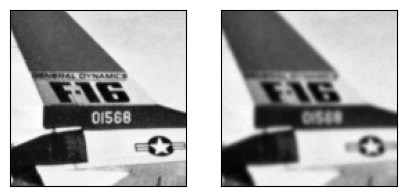

In [35]:
# Read image and create degraded version

im = read_img('data/airplane.tif', as_tensor=True).to(device)
ker = gaussian_kernel(sigma=1.2, as_tensor=True).to(device)

im_blur = blur(im, ker)
im_blur_noisy = gaussian_noise(im_blur, sigma=1e-2)

fig, axes = plt.subplots(1,2, figsize=(5,10))
axes[0].imshow(to_numpy(im), cmap='gray')
axes[1].imshow(to_numpy(im_blur_noisy), cmap='gray')
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()
#fig.savefig('figs/airplane_degraded.png', dpi=300, bbox_inches='tight', transparent=True)

In [30]:
nb_epoch = 2000
learning_rate = 0.01
input = (torch.rand(1,32,128,128)/10).to(device)
criterion = nn.MSELoss()

all_net_params = [{'feature_channels' : 128, 'skip_channels' : 4, 'depth' : 2},
                  {'feature_channels' : 128, 'skip_channels' : 4, 'depth' : 4},
                  {'feature_channels' : 128, 'skip_channels' : 4, 'depth' : 6}]
all_psnr = []
all_im_recon = []

for i_run in range(3):
    # Create network
    model = Unet(in_channels=input.shape[1], out_channels=1, **all_net_params[i_run])
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Optimizing loop
    model.train()
    for i_epoch in range(nb_epoch):
        optimizer.zero_grad()
        im_recon = model(input)
        loss = criterion(blur(im_recon, ker), im_blur_noisy)
        loss.backward()
        optimizer.step()
        if (i_epoch+1) % 100 == 0:
            metric = psnr(to_numpy(im), to_numpy(im_recon))
            print(' [-] Run {:} epoch {:}/{:}, loss {:.6f}, psnr {:.5f}'.format(i_run, i_epoch+1, nb_epoch, loss.item(), metric))
    all_psnr.append(psnr(to_numpy(im), to_numpy(im_recon)))
    all_im_recon.append(to_numpy(im_recon))

 [-] Run 0 epoch 100/2000, loss 0.004500, psnr 20.13163
 [-] Run 0 epoch 200/2000, loss 0.002177, psnr 22.24366
 [-] Run 0 epoch 300/2000, loss 0.001317, psnr 23.62205
 [-] Run 0 epoch 400/2000, loss 0.000878, psnr 24.71514
 [-] Run 0 epoch 500/2000, loss 0.000613, psnr 25.53523
 [-] Run 0 epoch 600/2000, loss 0.000563, psnr 25.87911
 [-] Run 0 epoch 700/2000, loss 0.000998, psnr 25.02692
 [-] Run 0 epoch 800/2000, loss 0.000423, psnr 26.71231
 [-] Run 0 epoch 900/2000, loss 0.000308, psnr 27.12456
 [-] Run 0 epoch 1000/2000, loss 0.000307, psnr 27.22413
 [-] Run 0 epoch 1100/2000, loss 0.000340, psnr 27.18457
 [-] Run 0 epoch 1200/2000, loss 0.000350, psnr 27.55825
 [-] Run 0 epoch 1300/2000, loss 0.000251, psnr 27.97788
 [-] Run 0 epoch 1400/2000, loss 0.000263, psnr 27.86442
 [-] Run 0 epoch 1500/2000, loss 0.000267, psnr 28.32211
 [-] Run 0 epoch 1600/2000, loss 0.000272, psnr 28.36590
 [-] Run 0 epoch 1700/2000, loss 0.000309, psnr 27.48320
 [-] Run 0 epoch 1800/2000, loss 0.00021

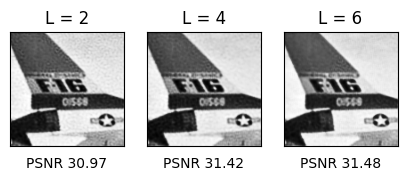

In [21]:
fig, axes = plt.subplots(1,3, figsize=(5,10))
for i_run in range(3):
  axes[i_run].imshow(all_im_recon[i_run], cmap='gray')
  axes[i_run].tick_params(axis=u'both', which=u'both',length=0)
  axes[i_run].set_xticklabels([])
  axes[i_run].set_yticklabels([])
  axes[i_run].set_title('L = {:}'.format(all_net_params[i_run]['depth']))
  axes[i_run].set_xlabel('PSNR {:.2f}'.format(all_psnr[i_run]))
plt.show()
#fig.savefig('figs/net_depth.png', dpi=300, bbox_inches='tight', transparent=True)